# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Загрузим необходимые библиотеки

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Загрузка данных

In [3]:
try:
    f_location_df = pd.read_csv('/datasets/geo_data_0.csv')
    s_location_df = pd.read_csv('/datasets/geo_data_1.csv')
    t_location_df = pd.read_csv('/datasets/geo_data_2.csv')
except:
    f_location_df = pd.read_csv('F:\\Учеба яндекс\\projects\\9_GRGN\\geo_data_0.csv')
    s_location_df = pd.read_csv('F:\\Учеба яндекс\\projects\\9_GRGN\\geo_data_1.csv')
    t_location_df = pd.read_csv('F:\\Учеба яндекс\\projects\\9_GRGN\\geo_data_2.csv')

Сохраним все ключевые значения для расчётов в отдельных переменных

In [4]:
NUM_OF_RES_POINTS = 500
NUM_OF_BEST_POINTS = 200
BUDGET = 10000000
BARREL_COST = 450

**Изучим данные**

In [5]:
def first_look(df):
    df.info()
    return display(df.describe(),df.head(10))

Изучим данные с первой локации

In [6]:
first_look(f_location_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Изучим данные со второй локации

In [7]:
first_look(s_location_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Изучим данные с третьей локации

In [8]:
first_look(t_location_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


**Вывод:** пропуски не обнаружены, данные логичны, порядок значений во всех столбцах тождественен для всех датасетов, при проведении предварительного анализа выбивающихся значений не обнаружено.

### Подготовка данных

#### Установим id в качестве индекса

In [9]:
f_location_df = f_location_df.set_index('id')
s_location_df = s_location_df.set_index('id')
t_location_df = t_location_df.set_index('id')

#### Проверим наличие строк-дубликатов

In [10]:
f_location_df.duplicated().sum()

0

In [11]:
s_location_df.duplicated().sum()

0

In [12]:
t_location_df.duplicated().sum()

0

### Проанализируем распределеине признаков более точно

In [13]:
def num_feature(feature):
    
#Построение диаграмм размаха
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,10))
    plt.title(f'Диаграмма размаха для {feature}')

    ax1.boxplot(f_location_df[feature])
    ax1.set_title(f'Диаграмма размаха 1-ой локации')
    
    ax2.boxplot(s_location_df[feature])
    ax2.set_title(f'Диаграмма размаха 2-ой локации')
    
    ax3.boxplot(t_location_df[feature])
    ax3.set_title(f'Диаграмма размаха 3-ей локации')
    
    plt.show()
#------------------------------------------------------------------
# Построение гистограмм

    f_location_df[feature].hist(bins = 15,
                                figsize = (9,7),
                                edgecolor='black',
                                label = 'first',
                                alpha = 0.5)
    s_location_df[feature].hist(bins = 15,
                                figsize = (9,7),
                                edgecolor='black',
                                label = 'second',
                                alpha = 0.5)
    t_location_df[feature].hist(bins = 15,
                                figsize = (9,7),
                                edgecolor='black',
                                label = 'third',
                                alpha = 0.5)
    plt.title(f'Гистограмма {feature}', size = 15)
    plt.ylabel('Количество записей', size = 12)
    plt.xlabel(feature, size = 12)
    plt.legend()
    plt.show()

#### Рассмотрим признак f0

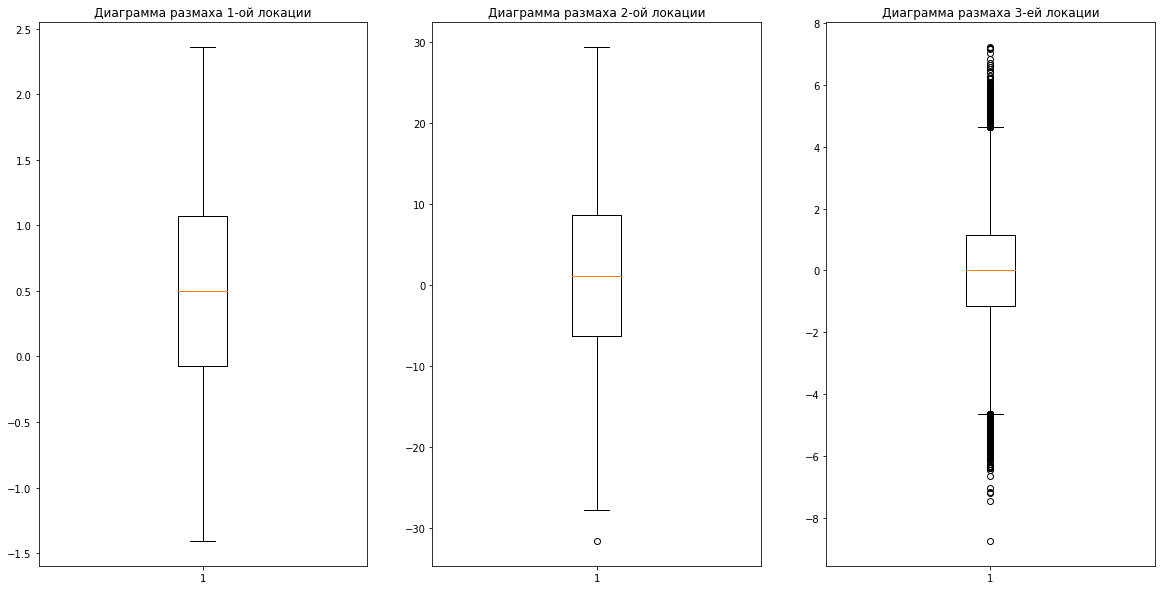

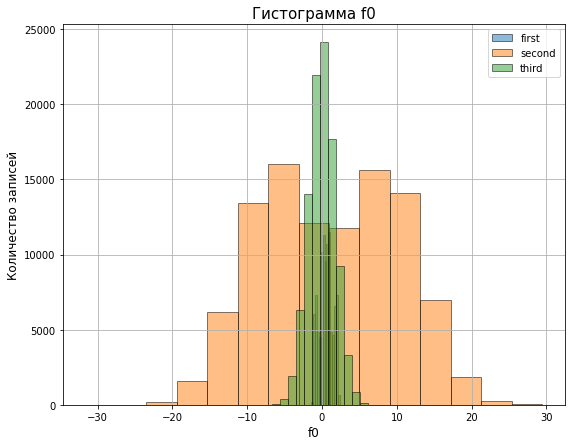

In [14]:
num_feature('f0')

Можно заметить, что для второй и третьей локации значения признака f0 распределены вокруг 0. Для первой локации сосредоточение вокруг 0.5 самое плотное, для третьей локации - сосредоточение менее плотное, для второй - наименее плотное.

#### Рассмотрим признак f1

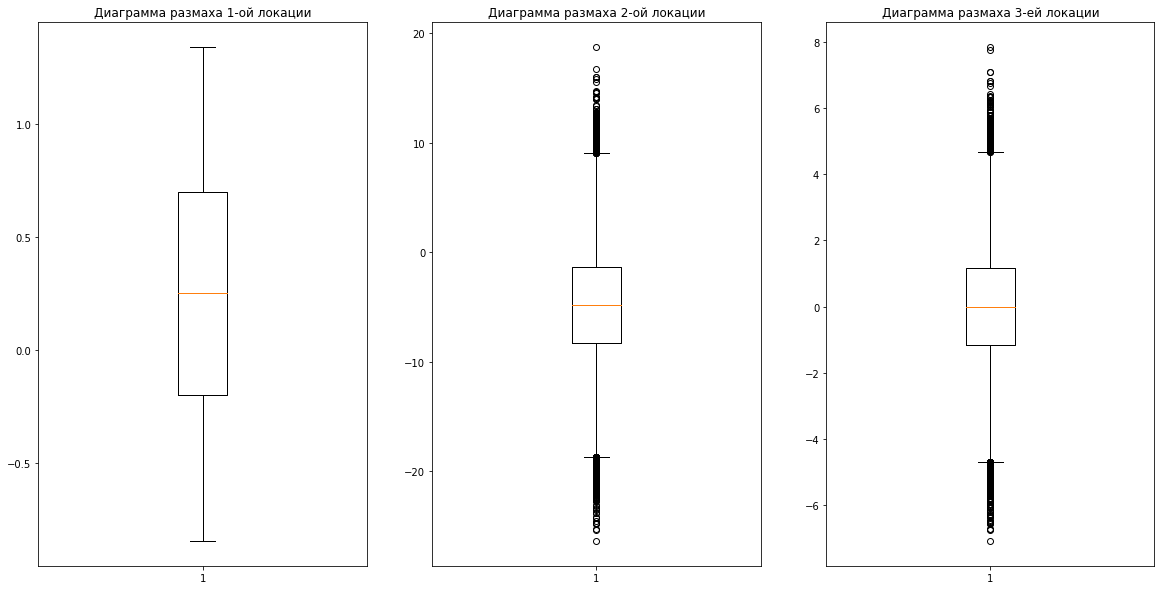

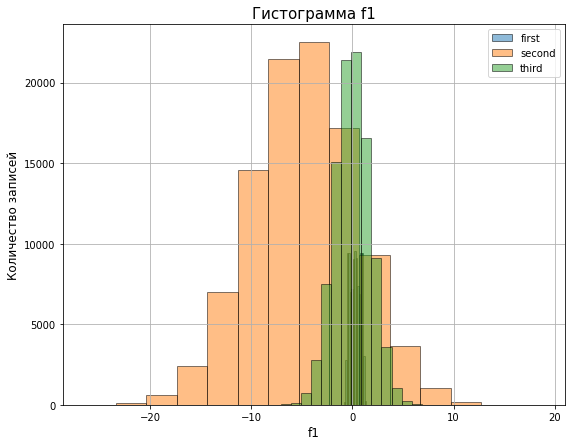

In [15]:
num_feature('f1')

Из анализа видно, что признак f1 для первой и третеьй локации распределены вокруг 0 с достаточно высокой плотностью, на второй локации признак распределен вокруг ~-5 с наименьшей плотностью.

#### Рассмотрим признак f2

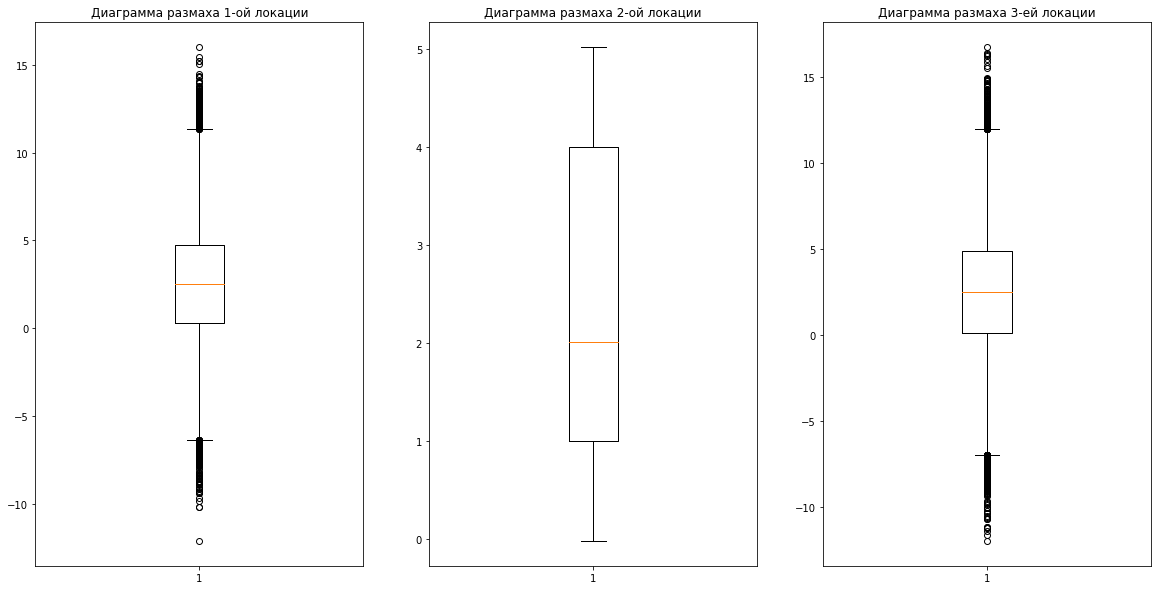

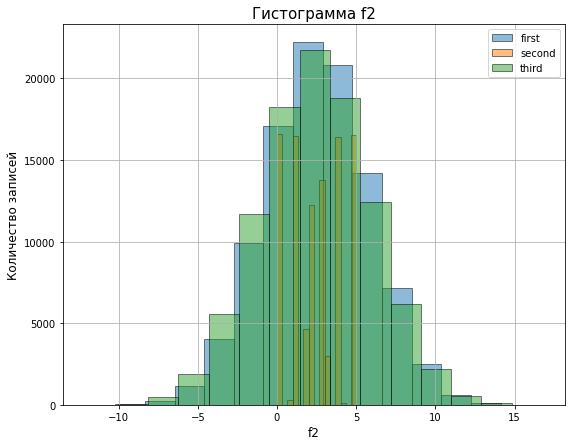

In [16]:
num_feature('f2')

Признак f2 для первой и третьей локации распределен достаточно свободно вокруг ~2.5, для второй - наиболее плотно вокруг 2.

#### Рассмотрим целевой признак

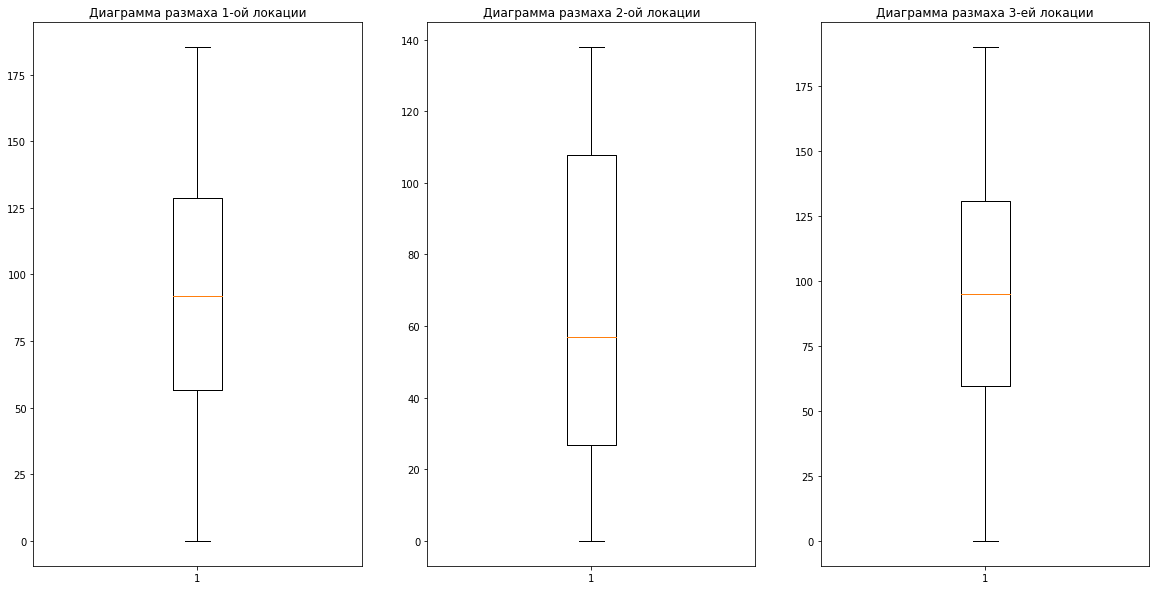

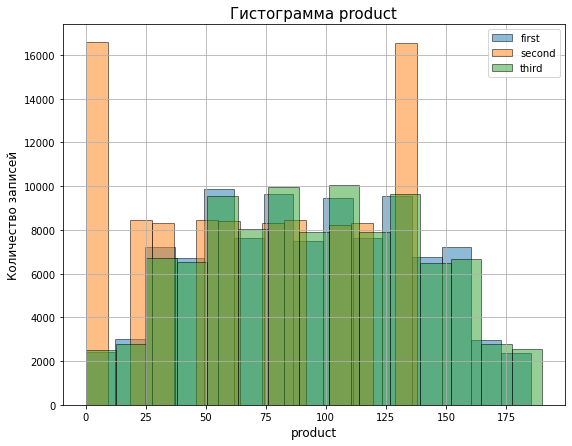

In [17]:
num_feature('product')

Распределеине объема запасов нефти в скважине для первой и третьей локации довольно схожее, близко к нормальному со средним около 93.75. Для второй локации можно заметить большУю часть скважин с околонулевым запасом, также наблюдается пик числа скважин с запасом около 130 тыс. баррелей.

### Корреляционный анализ

Проведем корреляционный анализ с целью обнаружения высокой корреляции между входными признаками и утечки целевого.

In [18]:
dfs = [f_location_df, s_location_df, t_location_df]

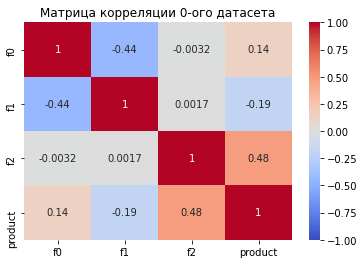

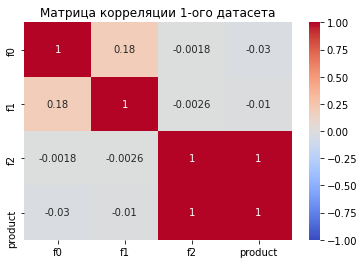

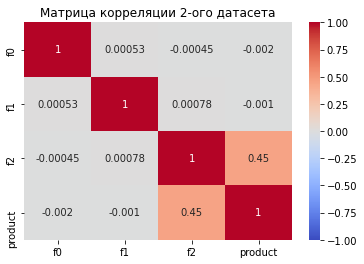

In [19]:
for i in range(len(dfs)):
    sns.heatmap(dfs[i].corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
    plt.title(f'Матрица корреляции {i}-ого датасета')
    plt.show()

Из проведенного анализа видно, что для 2-ого датасета наблюдается прямая корреляция между входным и целевым признаком.

## Обучение и проверка модели

In [20]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
num_columns = f_location_df.drop(['product'],axis = 1).columns.to_list()

In [21]:
preprocessor = ColumnTransformer(
[('num', StandardScaler(),num_columns)])

In [22]:
model = Pipeline(
[('preprocessor', preprocessor),
('model', LinearRegression())])

In [23]:
def remain_analize(truth,prediction):
    data = truth - prediction
    display(data.describe())
    data.plot(x = prediction, style ='o', grid = True, figsize = (9,7))
    plt.title('Диаграмма рассеяния остатков', size = 15)
    plt.ylabel('Ошибка, тыс. баррелей', size = 12)
    plt.xlabel('Предсказанные значения, тыс. баррелей', size =12)
    plt.show()
    data.hist(bins = 15, figsize = (9,7), edgecolor='black')
    plt.title('Гистограмма остатков', size = 15)
    plt.ylabel('Количество ошибок', size = 12)
    plt.xlabel('Ошибка, тыс. баррелей', size = 12)
    plt.axvline(data.mean(), color='r', label = 'Среднее')
    plt.legend()
    plt.show()

### Первый регион

In [24]:
X_train,X_valid,y_train,y_valid = train_test_split(
    f_location_df.drop(['product'],axis = 1),
    f_location_df['product'],
    random_state = RANDOM_STATE,
    test_size = TEST_SIZE)

In [25]:
X_train.shape

(75000, 3)

In [26]:
model.fit(X = X_train,y = y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression())])

In [27]:
f_location_predicted_product = pd.Series(model.predict(X_valid), index = y_valid.index)
f_location_true_product = y_valid

In [28]:
print(f'Метрика rmse модели:\n{mean_squared_error(y_valid, f_location_predicted_product, squared = False):.1f}')
print(f'\nСредний запас предсказанного сырья: {np.mean(model.predict(X_valid)):.1f} тыс. баррелей')

Метрика rmse модели:
37.8

Средний запас предсказанного сырья: 92.4 тыс. баррелей


Проведем анализ остатков

count    25000.000000
mean        -0.072844
std         37.757285
min       -119.074439
25%        -27.917279
50%         -0.098192
75%         27.594907
max        121.520866
Name: product, dtype: float64

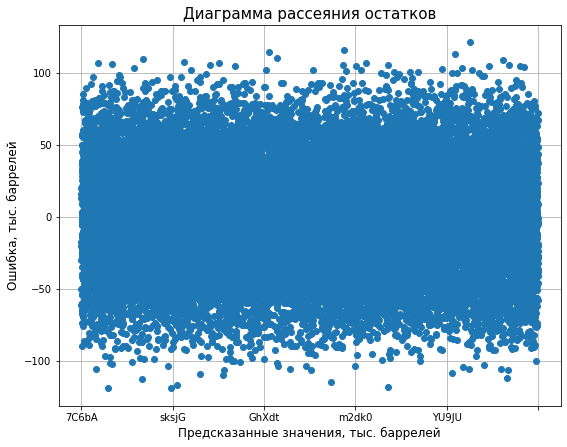

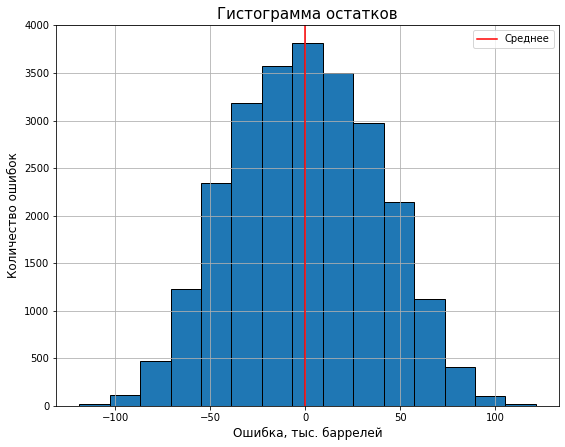

In [29]:
remain_analize(y_valid, model.predict(X_valid))

### Второй регион

In [30]:
X_train,X_valid,y_train,y_valid = train_test_split(
    s_location_df.drop(['product'],axis = 1),
    s_location_df['product'],
    random_state = RANDOM_STATE,
    test_size = TEST_SIZE)

In [31]:
X_train.shape

(75000, 3)

In [32]:
model.fit(X = X_train,y = y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression())])

In [33]:
s_location_predicted_product = pd.Series(model.predict(X_valid), index = y_valid.index)
s_location_true_product = y_valid

In [34]:
print(f'Метрика rmse модели:\n{mean_squared_error(y_valid, s_location_predicted_product, squared = False):.1f}')
print(f'\nСредний запас предсказанного сырья: {np.mean(model.predict(X_valid)):.1f} тыс. баррелей')

Метрика rmse модели:
0.9

Средний запас предсказанного сырья: 68.7 тыс. баррелей


Проведем анализ остатков

count    25000.000000
mean         0.012503
std          0.890210
min         -3.225857
25%         -0.600196
50%          0.014993
75%          0.625869
max          3.322995
Name: product, dtype: float64

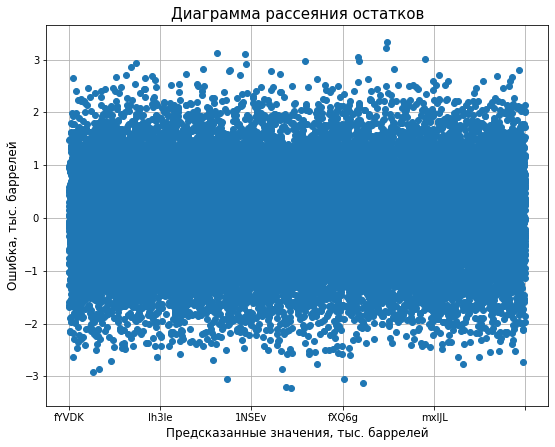

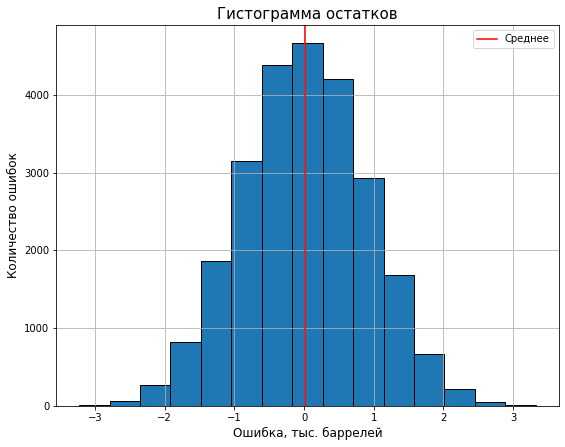

In [35]:
remain_analize(y_valid, model.predict(X_valid))

### Третий регион

In [36]:
X_train,X_valid,y_train,y_valid = train_test_split(
    t_location_df.drop(['product'],axis = 1),
    t_location_df['product'],
    random_state = RANDOM_STATE,
    test_size = TEST_SIZE)

In [37]:
X_train.shape

(75000, 3)

In [38]:
model.fit(X = X_train,y = y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression())])

In [39]:
t_location_predicted_product = pd.Series(model.predict(X_valid), index = y_valid.index)
t_location_true_product = y_valid

In [40]:
print(f'Метрика rmse модели:\n{mean_squared_error(y_valid, t_location_predicted_product, squared = False):.1f}')
print(f'\nСредний запас предсказанного сырья: {np.mean(model.predict(X_valid)):.1f} тыс. баррелей')

Метрика rmse модели:
40.1

Средний запас предсказанного сырья: 94.8 тыс. баррелей


Проведем анализ остатков

count    25000.000000
mean         0.379975
std         40.144877
min       -131.400392
25%        -29.053845
50%          0.192387
75%         29.254412
max        126.349866
Name: product, dtype: float64

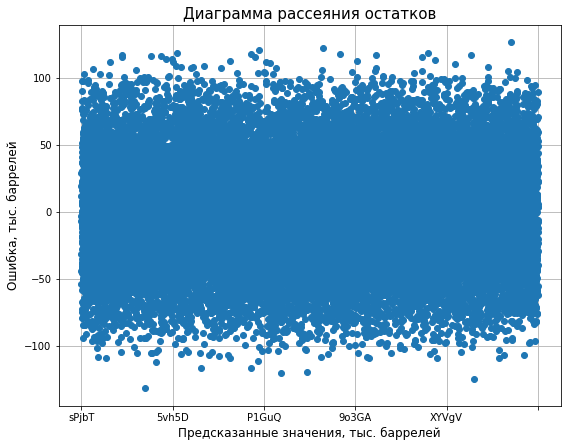

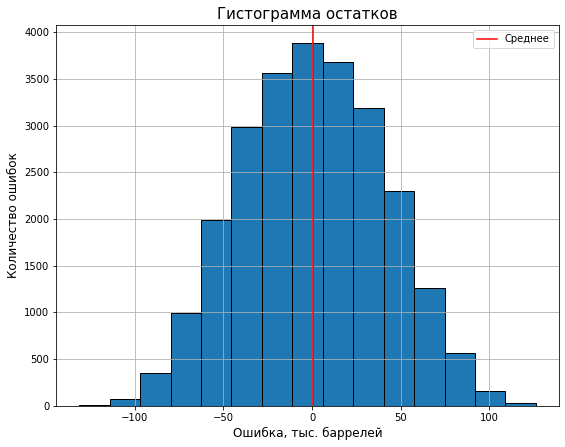

In [41]:
remain_analize(y_valid, model.predict(X_valid))

**Вывод:** проведено обучение трех моделей линейной регрессии для всех предложенных регионов. Вычислена метрика RMSE для моделей, а также средний предсказанный запас нефти.

## Подготовка к расчёту прибыли

Рассчитаем достаточный для безубыточной разработки новых скважин объем сырья

In [42]:
enough_prod = BUDGET / (NUM_OF_BEST_POINTS * BARREL_COST)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины равен {enough_prod:.2f} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины равен 111.11 тыс. баррелей


Напишем функцию для определения прибыли от разработки новых скважин

In [43]:
def income(y_true, predictions):
    return (np.sum(y_true[predictions
                          .sort_values(ascending = False)
                          .head(NUM_OF_BEST_POINTS).index]
                   *BARREL_COST) - BUDGET) * 1000

**Вывод:** таким образом, достаточный объём сырья для безубыточной разработки новой скважины равен 111.11 тыс. баррелей.

## Расчёт прибыли и рисков 

In [44]:
state = np.random.RandomState(12345)
    
y_true_ser = [f_location_true_product, s_location_true_product, t_location_true_product]
y_pred_ser = [f_location_predicted_product, s_location_predicted_product, t_location_predicted_product]
    
for i in range(len(y_true_ser)):
    for j in range(len(y_pred_ser)):
        if i == j:
            values = []
            count = 0

            
            for k in range(1000):
                sampled_target = y_pred_ser[j].sample(n = NUM_OF_RES_POINTS,
                                                      replace = True, random_state = state)
                ones_income = income(y_true_ser[i],sampled_target)
                values.append(ones_income)
                  
            values = pd.Series(values)
            lower = values.quantile(0.025)
            upper = values.quantile(0.975)
            mean = values.mean()
            
            print('\n\nСредняя выручка:', round(mean,0))
            print(f'\nРиск убытков = {(values<0).sum()/10:.2f}%')
            print(f'\n95% Доверительный интервал:[{lower:.0f}, {upper:.0f}]')



Средняя выручка: 406278783.0

Риск убытков = 6.70%

95% Доверительный интервал:[-117742136, 911737051]


Средняя выручка: 441504278.0

Риск убытков = 1.60%

95% Доверительный интервал:[35728489, 828006639]


Средняя выручка: 385213196.0

Риск убытков = 7.80%

95% Доверительный интервал:[-164785166, 888206234]


<div class="alert alert-info">    
Поправил
</div>

**Вывод:** на основании проведенного анализа можно рекомендовать к разработке скважины со второй локации, так как с вероятностью 95% доход от реализации проекта будет лежать в диапазоне [35728489, 828006639], средняя выручка при этом составляет 441.5 млн. руб., риск убытков равен 1.6%.

### Общий вывод

В настоящей работе было проведено исследование данных, предоставленных добывающей компании «ГлавРосГосНефть», в ходе которого обучены и применены 3 модели линейной регрессии с целью поиска наилучшей локации для бурения новых скважин.

Этапы работы:

**Предобработка данных** которая включала анализ наличия пропусков, проверено наличие дубликатов, в качетсве индекса установлены id. Выяснено, что данные логичны, порядок значений во всех столбцах тождественен для всех датасетов, выбивающихся значений не обнаружено.

**Исследовательский анализ данных**, в ходе которого были проанализированы: ***f0***: можно заметить, что для второй и третьей локации значения признака распределены вокруг 0, для первой локации сосредоточение вокруг 0.5 самое плотное, для третьей локации - сосредоточение менее плотное, для второй - наименее плотное; ***f1***: признак для первой и третеьй локации распределен вокруг 0 с достаточно высокой плотностью, на второй локации признак распределен вокруг ~-5 с наименьшей плотностью; ***f2***:  для первой и третьей локации распределен достаточно свободно вокруг ~2.5, для второй - наиболее плотно вокруг 2; ***объём запасов в скважине***: распределеине для первой и третьей локации довольно схожее, близко к нормальному со средним около 93.75. Для второй локации можно заметить большУю часть скважин с околонулевым запасом, также наблюдается пик числа скважин с запасом около 130 тыс. баррелей. Корреляционный анализ показал наличие прямой связи между целевым признаком и признаком f2 для второго датасета.

**Разработка и применение ML-моделей линейной регрессии для прогнозирования объемов запасов в скважине**: проведено обучение трех моделей линейной регрессии для всех предложенных регионов. Вычислена метрика RMSE для моделей, а также средний предсказанный запас нефти.
* Первый регион: метрика rmse модели: 37.8, средний запас предсказанного сырья: 92.4 тыс. баррелей;
* Второй регион: метрика rmse модели: 0.9, средний запас предсказанного сырья: 68.7 тыс. баррелей;
* Третий регион: метрика rmse модели: 40.1, средний запас предсказанного сырья: 94.8 тыс. баррелей;

**Расчет прибыли и рисков безубыточной реализации проекта**: с помощью техники Bootstrap с 1000 выборок найдено распределение прибыли от разработки скважин в регионе, найдена средняя прибыль и 95% интервал прибыли. Определен регион с наибольшей прибылью для соответствующей 2.5% квантилю степени риска. Наилучшей для бурения определена вторая локация, так как с вероятностью 95% доход от реализации проекта будет лежать в диапазоне [35728489, 828006639], средняя выручка при этом составляет 441.5 млн. руб., риск убытков равен 1.6%.